In [9]:
import numpy as np

from triqs.gf import *
from triqs.gf.meshes import MeshDLRImFreq, MeshDLRImTime

from triqs.gf import *
from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *

from triqs.atom_diag import *

import numpy as np
from itertools import product
import matplotlib.pylab as plt
import time
from triqs.plot.mpl_interface import oplot,plt

from gwsolver import GWSolver

def number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu):
    Hmu = H + mu * number_operator
    atomic_diagonal = AtomDiagComplex(Hmu, fundamental_operators)
    density_matrix = atomic_density_matrix(atomic_diagonal, beta)
    filling = trace_rho_op(density_matrix, number_operator, atomic_diagonal)
    return filling.real, atomic_diagonal

def fix_atomic_diag(H, fundamental_operators, target_occupation, number_operator, beta, mu = None, eps = 1e-6):
    if mu is None:
        mu = 0

    step = 1.0

    occupation, atomic_diagonal = number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu)

    previous_direction = None
    iterator = 0
    while abs(occupation - target_occupation) > eps:
        if occupation - target_occupation > 0:
            if previous_direction == 'decrement':
                step /= 2
            previous_direction = 'increment'
            mu += step
        if occupation - target_occupation < 0:
            if previous_direction == 'increment':
                step /= 2
            previous_direction = 'decrement'
            mu -= step
        occupation, atomic_diagonal = number_of_particles_from_ad(H, fundamental_operators, number_operator, beta, mu)
        iterator += 1
        # print(f"ED Iteration {iterator}: mu = {mu}, N = {occupation}", end='\r')
    return atomic_diagonal, mu

def exact_diag(tij, V, occupation = None, beta = 100, nw = 1 * 1024):
    spin_names = ['up', 'dn']
    orbital_names = range(len(tij))

    if occupation is None:
        occupation = len(tij)

    fundamental_operators = [(spin_name, orbital_name) for spin_name, orbital_name in product(spin_names, orbital_names)]

    N = 0
    for i in orbital_names:
        N += n('up', i) + n('dn', i)

    H = h_int_slater(spin_names, len(orbital_names), V, off_diag = True, complex = True)
        
    for spin, i, j in product(spin_names, orbital_names, orbital_names):
        H += tij[i, j] * c_dag(spin, i) * c(spin, j)
        
    atomic_diagonal, mu = fix_atomic_diag(H, fundamental_operators, occupation, N, beta)

    gf_struct = [('dn', len(orbital_names)),
                ('up', len(orbital_names))]

    G_w = atomic_g_iw(atomic_diagonal, beta, gf_struct, nw)
    return G_w


def exact_polarization(mesh, t):
    g = Gf(mesh = mesh, target_shape = [2, 2])

    indices = (0, 1)
    for i, j in product(indices, indices):
        for w in mesh:
            g[w][i, j] = (-1) ** (i - j) * (1 / (w - 2 * t) - 1 / (w + 2 * t)) / 4
 
    return BlockGf(block_list = [g] * 2, name_list = ['up', 'dn'], make_copies = False)

def exact_screened_potential(mesh, t, U):
    g = Gf(mesh = mesh, target_shape = [2, 2])

    h_sqrd = 4 * t ** 2 + 4 * U * t

    indices = (0, 1)
    for i, j in product(indices, indices):
        for w in mesh:
            g[w][i, j] = U * int(i == j) + (-1) ** (i - j) * 2 * U ** 2 * t / (complex(w) ** 2 - h_sqrd)
 
    return BlockGf(block_list = [g] * 2, name_list = ['up', 'dn'], make_copies = False)


def exact_self_energy(mesh, t, U):
    g = Gf(mesh = mesh, target_shape = [2, 2])

    h_sqrd = 4 * t ** 2 + 4 * U * t
    h = np.sqrt(h_sqrd)

    indices = (0, 1)
    for i, j in product(indices, indices):
        for w in mesh:
            g[w][i, j] = U * int(i == j) + U ** 2 * t * (1 / (w - t - h) + (-1) ** (i - j) / (w + t + h)) / (2 * h)
 
    return BlockGf(block_list = [g] * 2, name_list = ['up', 'dn'], make_copies = False)


def exact_self_g(mesh, t, U, interacting = True):
    u = U * int(interacting)
    g = Gf(mesh = mesh, target_shape = [2, 2])

    h_sqrd = 4 * t ** 2 + 4 * u * t
    h = np.sqrt(h_sqrd)

    A = np.sqrt((2 * t + h + u / 2) ** 2 + 4 * u ** 2 * t / h)
    B = np.sqrt((2 * t + h - u / 2) ** 2 + 4 * u ** 2 * t / h)

    w1p = 0.5 * (u / 2 - h + A)
    w1m = 0.5 * (u / 2 - h - A)
    w2p = 0.5 * (u / 2 + h + B)
    w2m = 0.5 * (u / 2 + h - B)

    indices = (0, 1)
    for i, j in product(indices, indices):
        for w in mesh:
            g[w][i, j] = (-1) ** (i - j) * ((0.25 + (h + 2 * t + u / 2) / (4 * A)) / (w - w1p) + (0.25 - (h + 2 * t + u / 2) / (4 * A)) / (w - w1m)) \
                         + (0.25 + (-h - 2 * t + u/2) / (4 * B)) / (w - w2p) + (0.25 - (-h - 2 * t + u/2) / (4 * B)) / (w - w2m)
 
    return BlockGf(block_list = [g] * 2, name_list = ['up', 'dn'], make_copies = False)


def generate_g0_w(tij, mesh, spin_names = ['up', 'dn']):
    g_inv = Gf(mesh = mesh, target_shape = np.shape(tij))
    g_inv << iOmega_n - tij.transpose()
    g = g_inv.inverse()
    return BlockGf(block_list = [g] * 2, name_list = spin_names, make_copies = False)

def coulomb_matrix(orbitals, U, non_local = True):
    Vij = np.zeros([orbitals] * 2)
    for i in range(orbitals):
        for j in range(orbitals):
            Vij[i, j] = round(0.5 * U / (abs(i - j) + 1), 2)

        Vij[i, i] = U
    if non_local:
        return Vij

    return np.diag(Vij.diagonal())


def coulomb_tensor(orbitals, U, non_local = True):
    Vij = coulomb_matrix(orbitals, U, non_local)
    Vijkl = np.zeros([orbitals] * 4)
    for i in range(orbitals):
        for j in range(orbitals):
            Vijkl[i, j, i, j] = Vij[i, j]
    return Vijkl

orbitals = 2
occupation = 2

t = 1.0

tij = np.zeros([orbitals] * 2)
for i in range(orbitals - 1):
    tij[i, i + 1] = -t
    tij[i + 1, i] = -t

U = 0.5
non_local = True
Vij = coulomb_matrix(orbitals, U, non_local = non_local)
Vijkl = coulomb_tensor(orbitals , U, non_local = non_local)

beta = 100

iw_mesh_f = MeshDLRImFreq(beta = beta, statistic = 'Fermion',  w_max = 5.0, eps = 1e-15)
iw_mesh_b = MeshDLRImFreq(beta = beta, statistic = 'Boson',  w_max = 5.0, eps = 1e-15)
g0_w = generate_g0_w(tij, iw_mesh_f)

gw = GWSolver(g0_w, Vij, self_interactions = True, hartree_flag = True, fock_flag = True, N_fix = occupation)

# P = exact_polarization(iw_mesh_b, t)
# W = exact_screened_potential(iw_mesh_b, t, U)
# Sigma = exact_self_energy(iw_mesh_f, t, U)
# G = exact_self_g(iw_mesh_f, t, U)
# G0 = exact_self_g(iw_mesh_f, t, U, interacting = False)

ED = exact_diag(tij, Vijkl, occupation, beta = beta, nw = 1 * 1024)

# sigma = gw.g0_w.inverse() - gw.g_w.inverse()
# sigma = G0.inverse() - G.inverse()

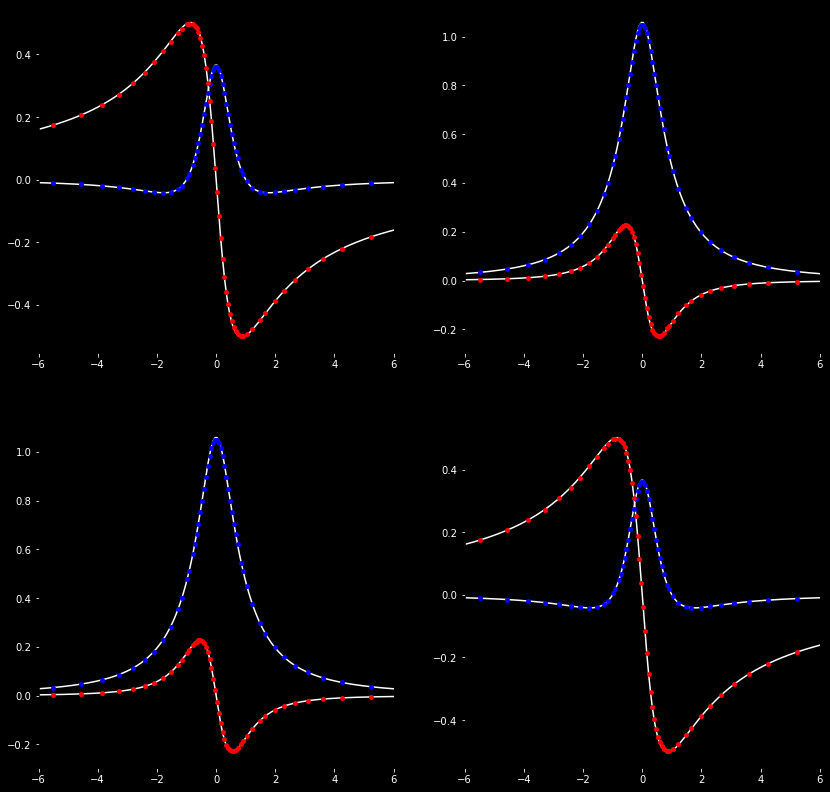

In [10]:
fig, axs = plt.subplots(orbitals, orbitals, figsize = (7 * orbitals, 7 * orbitals), facecolor = 'black')
spin = 'up'

a = gw.g_w
b = ED

for i in range(orbitals):
    for j in range(orbitals):
        axs[i, j].set_facecolor('black')
        axs[i, j].xaxis.label.set_color('white')
        axs[i, j].tick_params(axis = 'x', colors = 'white')
        axs[i, j].yaxis.label.set_color('white')
        axs[i, j].tick_params(axis = 'y', colors = 'white')
        axs[i, j].set_xlim(-6, 6)

        axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].real, color = 'blue', zorder = 1, s = 15)
        axs[i, j].scatter([w.imag for w in a.mesh.values()], a[spin].data[:, i, j].imag, color = 'red', zorder = 1, s = 15)

        axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].real, color = 'white', zorder = 0)
        axs[i, j].plot([w.imag for w in b.mesh.values()], b[spin].data[:, i, j].imag, color = 'white', zorder = 0)